In [60]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from src.fractions_utils import FracContext, FractionalEncoderUtils, FractionalDecryptorUtils
from src.encarray import EncArray
from src.linear_regression import SecureLinearRegression
from src.main import generate_dataset

from time import time
from matplotlib import pyplot
from sklearn.datasets import make_regression
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


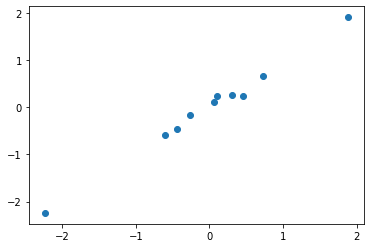

In [93]:
X, y = generate_dataset(10, 1, 10)
X_without_intercept = X[:,0]
X = X.tolist()
y = y.tolist()
pyplot.scatter(X_without_intercept, y)
pyplot.show()

In [90]:
X

[-1.407, 0.537, 0.808, 1.081, 0.537, -1.257, -0.281, -0.734, 1.616, -0.901]

In [87]:
context = FracContext()
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 2400 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19


## Timings of basic HE operations

In [19]:
# testing numbers
a = 13
b = 42

In [ ]:
## time for encoding

In [101]:
%%timeit
enc_a = encode_utils.encrypt_num(a)
enc_b = encode_utils.encrypt_num(b)


16.9 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
%%timeit
encode_utils.add(enc_a, enc_b)

TypeError: can't pickle seal.Encryptor objects

In [ ]:
%%timeit
encode_utils.substract(enc_a, enc_b)

In [98]:
%%timeit
enc_a = EncArray(a, encode_utils)
enc_b = EncArray(b, encode_utils)

17.2 ms ± 59.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%%timeit
enc_a + enc_b

74.5 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit
enc_a - enc_b

50.7 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
%%timeit
enc_a * enc_b

236 ms ± 6.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timings of Linear Regression model 

In [94]:
X_enc = EncArray(X, encode_utils)
y_enc = EncArray(y, encode_utils)

In [95]:
%%timeit
model = SecureLinearRegression()
model.fit_unencrypted(X, y, n_iter=10)

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. 

Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. 

Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. 

Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. 

Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. 

Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. 

Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. 

Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. 

Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. 

Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. 

Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. 

Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. 

Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. 

Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. 

Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. 

Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. 

Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. 

Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. 

Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. Gradient: [-5.09826089e+00 -1.94289029e-16]
Iteration: 4. Gradient: [-4.07860871e+00 -1.52655666e-16]
Iteration: 5. Gradient: [-3.26288697e+00 -2.77555756e-16]
Iteration: 6. Gradient: [-2.61030957e+00 -1.11022302e-16]
Iteration: 7. Gradient: [-2.08824766e+00  1.38777878e-16]
Iteration: 8. Gradient: [-1.67059813e+00 -1.38777878e-16]
Iteration: 9. Gradient: [-1.33647850e+00 -2.22044605e-16]
Iteration: 0. Gradient: [-9.95754080e+00 -5.55111512e-16]
Iteration: 1. Gradient: [-7.96603264e+00 -3.60822483e-16]
Iteration: 2. Gradient: [-6.37282611e+00 -5.82867088e-16]
Iteration: 3. 

In [96]:
%%timeit
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=10, decode_utils=decode_utils, verbose=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2


KeyboardInterrupt: 

## Timings of different initialization parameters

In [ ]:
context = FracContext(poly_modulus="1x^512 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=False)

In [ ]:
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=40, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=False)

In [ ]:
context = FracContext(poly_modulus="1x^2048 + 1", coef_modulus_n_primes=80, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=False)